In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/PR_HW3/lfw.zip" -d "/content/drive/MyDrive/PR_HW3/lfw"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/PR_HW3/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/drive/MyDrive/PR_HW3/lfw/lfw/Recep_Tayyip_Erdogan/R

In [4]:
path = '/content/drive/MyDrive/PR_HW3/lfw/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print ("Cuda found.")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  print ("MPS found.")
else:
  print ("Cuda or MPS device not found.")


Cuda found.


torch.Size([250, 250, 3])


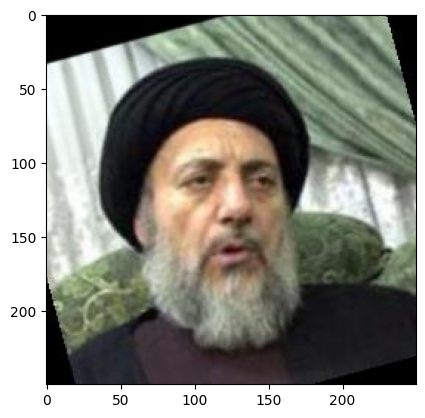

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [16]:
sample_image, _ = next(iter(dataloader))

print("Dimensions:", sample_image.shape)

Dimensions: torch.Size([32, 3, 250, 250])


**Dimensions:**
The sample image tensor shape from the dataloader is ([32, 3, 250, 250]) and the pytorch image shape will return (batch_size, channels, height, width).

Here, The sample image from the dataloader has



*   **Batch size of - 32:** Which means no.of images in the batch.
*   **Channels size - 3:** Channel represents no.of color channels, since the images are color images we have 3 channels "Red, Green, Blue".
*   **Height - 250:** Height represents the height of the image which is 250.
*   **Width - 250:** Width represents the width of the image which is 250.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [17]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()

         # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_relu1 = nn.ReLU()
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_relu2 = nn.ReLU()

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(32)
        self.decoder_relu1 = nn.ReLU()
        self.decoder_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_sigmoid = nn.Sigmoid()

         # Upsample and convolution to get the correct size
        self.decoder_upsample = nn.Upsample(size=(250, 250), mode='nearest')
        self.decoder_final_conv = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        self.decoder_sigmoid = nn.Sigmoid()

    def encoder(self,x):
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)

        return x

    def decoder(self,x):
        x = self.decoder_conv1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)
        x = self.decoder_conv2(x)
        x = self.decoder_upsample(x)
        x = self.decoder_final_conv(x)
        x = self.decoder_sigmoid(x)

        return x

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [18]:
autoencoder = AE()

model = torch.randn((32, 3, 250, 250))
output_image = autoencoder(model)

encoded_output = autoencoder.encoder(model)
decoded_output = autoencoder.decoder(encoded_output)

print("Original image shape:", model.shape)
print("Encoder output:", encoded_output.shape)
print("Decoder output:", decoded_output.shape)

Original image shape: torch.Size([32, 3, 250, 250])
Encoder output: torch.Size([32, 64, 63, 63])
Decoder output: torch.Size([32, 3, 250, 250])


Here, The input image size is [3, 250, 250]

The encoded output is [64, 63, 63], It is noticed that encoded output is reduced size.

After decoding the decoder output is same as the input image size


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [19]:
#Total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

loss_function = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

print("Loss Function:", loss_function)


Total number of trainable parameters: 43171
Loss Function: MSELoss()


**Loss Function:**


Loss function measures the difference between the input and the reconstructed output.

After the observation of loss functions, The most commonly used loss function for image reconstruction is MSE (Mean Squared Error) loss function which is being used in this model.

It measures the average squared difference between corresponding elements of the input and output tensors.


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [20]:
autoencoder = autoencoder.to(device)

num_epochs = 15

for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (inputs, _) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = inputs.to(device)

        # Forward pass
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/15, Loss: 0.00450318066402145
Epoch 2/15, Loss: 0.0015544714951653772
Epoch 3/15, Loss: 0.0013289519678182666
Epoch 4/15, Loss: 0.0012737406124720791
Epoch 5/15, Loss: 0.0011761554262087936
Epoch 6/15, Loss: 0.0011299942789660038
Epoch 7/15, Loss: 0.00109833822170034
Epoch 8/15, Loss: 0.0010705440643171504
Epoch 9/15, Loss: 0.0010177337659853579
Epoch 10/15, Loss: 0.0009861370421505133
Epoch 11/15, Loss: 0.0009805194795658083
Epoch 12/15, Loss: 0.0009635283761030144
Epoch 13/15, Loss: 0.0009667786224329043
Epoch 14/15, Loss: 0.000933250997936497
Epoch 15/15, Loss: 0.0009497707588193209


In this model I've used around 15 epochs and after each epoch it was noticed that loss is decreasing gradually to 0.0009.

If the loss is not decreasing we may have to do following troubleshooting steps:

*   Learning Rate Adjustment: We need to adjust the learning rate if it is too high or too low.
*   Model Complexity: Need to adjust the architecture of auto encoder.
*   Data Quality:Need to ensure that input data is properly preprocessed and free from any anomalies.
*   Gradient Clipping: We can also use gradient clipping to limit the gradient values during optimization.
*  Early Stopping:In order to eliminate overfitting we can stop the training if validation loss starts to increase.

By troubleshooting the above steps we can enhance the training performance of the autoencoder model.









##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

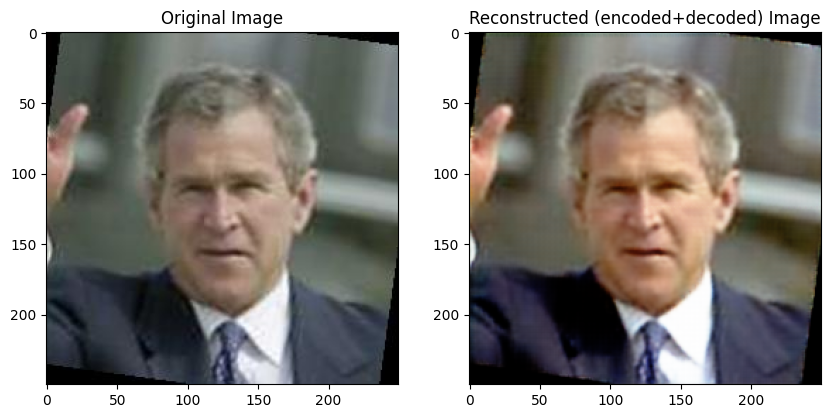

In [24]:
dataiter = iter(dataloader)
original_images, _ = next(dataiter)

original_image = TF.to_pil_image(original_images[0])
original_image_np = TF.to_tensor(original_image).numpy().transpose(1, 2, 0)
input_image = original_images[0].unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed = autoencoder(input_image)
    reconstructed_np = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed (encoded+decoded) Image")
plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

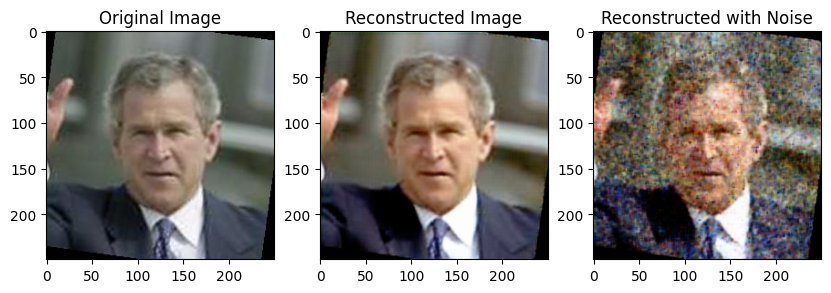

In [25]:

with torch.no_grad():
    encoded = autoencoder.encoder(input_image)

    noise = torch.randn_like(encoded) * 0.6
    noisy_encoded = encoded + noise

    reconstructed = autoencoder.decoder(encoded)
    reconstructed_noisy = autoencoder.decoder(noisy_encoded)
    reconstructed_np = reconstructed.cpu().squeeze(0).detach().numpy().transpose(1, 2, 0)
    reconstructed_noisy_np = reconstructed_noisy.squeeze(0).cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_np)
plt.title("Reconstructed Image")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_noisy_np)
plt.title("Reconstructed with Noise")


plt.show()


Here in this step I'm using "torch.randn_like(encoded)" which generates random noise with same shape as encoded and multipliying by the factor 0.6 (random noise by a factor of 0.6) controls the magnitude or intensity of the noise added to the encoded tensor


**How is adding noise affecting the decoded image ?**


Adding noise to the encoded representation of an image in an autoencoder affects the quality and fidelity of the decoded output.

The injected noise introduces subtle distortions, blurriness, or variations, impacting the overall visual accuracy of the decoded output. Despite these artifacts, the autoencoder becomes more robust, adapting to uncertainties in the data and ensuring better performance across diverse input scenarios. The trade-off lies in achieving a balance between maintaining the authenticity of the reconstructed image and reinforcing the model's ability to handle various input conditions effectively.
